In [87]:
#Evaluate ACCESS-OM2-01 IAF Properties in Denman Region
#https://cchdo.ucsd.edu/search?bbox=105,-90,115,-50

In [90]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cartopy.crs as ccrs
import cmocean as cm
from collections import OrderedDict
import cftime
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client
import matplotlib.path as mpath

import cmocean.cm as cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

from pyproj import Proj, transform

In [99]:
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='gray', linewidth=0.5)

In [91]:
client = Client(n_workers=8)
client

Client Scheduler: tcp://127.0.0.1:35607 Dashboard: /proxy/40237/status,Cluster Workers: 8 Cores: 8 Memory: 100.00 GiB


#get long-term average
expt='025deg_jra55_iaf_omip2_cycle3'
start = '1971-01-01 00:00:00'
end = '2017-12-31 00:00:00'
ltm_temp = cc.querying.getvar(expt, variable='temp', 
                       session=session, frequency='1 monthly',
                       start_time=start, 
                       end_time=end).sel(time=slice(start,end)).mean(dim='time').chunk({'st_ocean':25, 'yt_ocean':540, 'xt_ocean':720})
#temp.load()
ltm_temp.load()
ltm_temp.shape

ltm_temp.to_dataset(name='ltm_temp').to_netcdf('ltm_temp_025_cycle3.nc')

In [8]:
def align_yaxis_np(ax1, ax2):
    """Align zeros of the two axes, zooming them out by same ratio"""
    axes = np.array([ax1, ax2])
    extrema = np.array([ax.get_ylim() for ax in axes])
    tops = extrema[:,1] / (extrema[:,1] - extrema[:,0])
    # Ensure that plots (intervals) are ordered bottom to top:
    if tops[0] > tops[1]:
        axes, extrema, tops = [a[::-1] for a in (axes, extrema, tops)]

    # How much would the plot overflow if we kept current zoom levels?
    tot_span = tops[1] + 1 - tops[0]

    extrema[0,1] = extrema[0,0] + tot_span * (extrema[0,1] - extrema[0,0])
    extrema[1,0] = extrema[1,1] + tot_span * (extrema[1,0] - extrema[1,1])
    [axes[i].set_ylim(*extrema[i]) for i in range(2)]

In [9]:
def lagcorr(x,y,lag=None,verbose=True):
    '''Compute lead-lag correlations between 2 time series.

    <x>,<y>: 1-D time series.
    <lag>: lag option, could take different forms of <lag>:
          if 0 or None, compute ordinary correlation and p-value;
          if positive integer, compute lagged correlation with lag
          upto <lag>;
          if negative integer, compute lead correlation with lead
          upto <-lag>;
          if pass in an list or tuple or array of integers, compute 
          lead/lag correlations at different leads/lags.

    Note: when talking about lead/lag, uses <y> as a reference.
    Therefore positive lag means <x> lags <y> by <lag>, computation is
    done by shifting <x> to the left hand side by <lag> with respect to
    <y>.
    Similarly negative lag means <x> leads <y> by <lag>, computation is
    done by shifting <x> to the right hand side by <lag> with respect to
    <y>.

    Return <result>: a (n*2) array, with 1st column the correlation 
    coefficients, 2nd column correpsonding p values.

    Currently only works for 1-D arrays.
    '''

    import numpy
    from scipy.stats import pearsonr

    if len(x)!=len(y):
        raise('Input variables of different lengths.')

    #--------Unify types of <lag>-------------
    if numpy.isscalar(lag):
        if abs(lag)>=len(x):
            raise('Maximum lag equal or larger than array.')
        if lag<0:
            lag=-numpy.arange(abs(lag)+1)
        elif lag==0:
            lag=[0,]
        else:
            lag=numpy.arange(lag+1)    
    elif lag is None:
        lag=[0,]
    else:
        lag=numpy.asarray(lag)

    #-------Loop over lags---------------------
    result=[]
    if verbose:
        print('\n#<lagcorr>: Computing lagged-correlations at lags:',lag)

    for ii in lag:
        if ii<0:
            result.append(pearsonr(x[:ii],y[-ii:]))
        elif ii==0:
            result.append(pearsonr(x,y))
        elif ii>0:
            result.append(pearsonr(x[ii:],y[:-ii]))

    result=numpy.asarray(result)

    return result

In [10]:
def pearsoncor(y1, y2):
    ## Looking for lagged correlations between two timeseries
    ## Assumes y1 is leading
    ## Avoid end effects by using only first 2/3rds of timeseries ...???
    ## Calculates effective sample size using lag1-autocorrelations (Kial Stewart)
    ## Also, finds sampe size by a second method thanks to Josue
    
    n = len(y1)
    nc = int(n/3.5) #end effects? I don't understand this line.
    
    # De-mean both timeseries
    y1t = y1-np.mean(y1)
    y2t = y2-np.mean(y2)    

    cor = np.zeros(nc)
    sig = np.zeros(nc)
    Neff = np.zeros(nc)
    for j in np.arange(0, nc):
        x1t = np.roll(y1t, j)[j:]#y1t[:-j]
        x2t = y2t[j:]
        
        # Compute Neff for each sample using the Kial Stewart/Darryn Waugh method:
        r1, tmp = scipy.stats.pearsonr(x1t[1:], np.roll(x1t, 1)[1:])
        r2, tmp = scipy.stats.pearsonr(x2t[1:], np.roll(x2t, 1)[1:])
        Neff[j] = n*(1-r1*r2)/(1+r1*r2)
        
        cor[j], sig[j] = scipy.stats.pearsonr(x1t, x2t)
    
    #Josue's alternate Neff method
    idx = np.arange(1,nc)
    sni = np.sum((1 - idx/nc) * cor[idx])
    n_star = 1 + 2 * sni
    Neff2 = n/n_star

    return cor, sig, Neff, Neff2

In [92]:
expt='01deg_jra55v140_iaf'
variable='ht'
ht = cc.querying.getvar('01deg_jra55v140_iaf','ht',session,n=1).sel(yt_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
ht.load()
print(ht.shape)

expt='01deg_jra55v140_iaf'
variable='hu'
hu = cc.querying.getvar('01deg_jra55v140_iaf','hu',session,n=1).sel(yu_ocean=slice(-90,-55))
#ht = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
hu.load()
print(hu.shape)

(584, 3600)
(583, 3600)


In [93]:
variable='xt_ocean'
xt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
xt_ocean.load()
print(xt_ocean.values)

variable='yt_ocean'
yt_ocean = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
yt_ocean.load()
print(yt_ocean.shape)

variable='area_t'
area_t = cc.querying.getvar(expt,variable,session, n=-1).fillna(1.0).astype(int) - 1
area_t.load()
print(area_t.shape)

[-280 -280 -280 ...   78   78   78]
(2700,)
(2700, 3600)


In [101]:
#var.where((var.lat<5) & (var.lat>-5) & (var.lon>190) & (var.lon<240),drop=True

tmask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
tmask = tmask.where(~xr.ufuncs.isfinite(tmask.where(yt_ocean>-60)))
tmask = ~xr.ufuncs.isnan(tmask).to_dataset(name='tmask')

#plt.xlim([-265,-254])
den_mask = ht.where(~xr.ufuncs.isfinite(ht.where(ht>1000)))
den_mask = den_mask.where(~xr.ufuncs.isfinite(den_mask.where(yt_ocean>-60)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean<-265)))
den_mask=den_mask.where(~xr.ufuncs.isfinite(den_mask.where(xt_ocean>-254)))
den_mask = ~xr.ufuncs.isnan(den_mask).to_dataset(name='den_mask')

den_mask

<xarray.Dataset>
Dimensions:   (xt_ocean: 3600, yt_ocean: 584)
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... -55.12 -55.07 -55.01
Data variables:
    den_mask  (yt_ocean, xt_ocean) bool False False False ... False False False

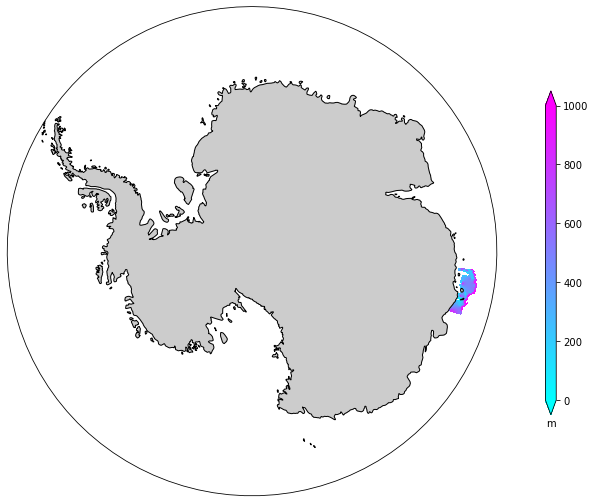

In [103]:
#plot mask for check
projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
#plt.suptitle('IAF Cycle 1, Big El Nino\'s Temp Anomaly at 200 m')

ax = plt.subplot(1, 1, 1, projection=projection)
ax.set_extent([-280, 80, -80, -62], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = ht.where(den_mask.den_mask).plot.pcolormesh(x='xt_ocean', y='yt_ocean', vmin=0, vmax=1000, add_colorbar=False, cmap=plt.cm.cool, extend='both', transform=ccrs.PlateCarree())

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1,cax=ax_cb, orientation='vertical', extend='both')
cb.ax.set_xlabel('m');

plt.tight_layout()

In [11]:
yrs=np.arange(1958.5,2019.5,1)

In [111]:
#Spatial averaging using mask area (more area to the west)
f=xr.open_dataset('../../ensoant/data/temp_zavg_200to500m_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
t1=f.t_zavg.where(den_mask.den_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t1.shape)

f=xr.open_dataset('../../ensoant/data/temp_zavg_200to500m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
t2=f.t_zavg.where(den_mask.den_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t2.shape)

t=xr.concat([t1,t2],'cycle')
print(t.shape,t1.shape,t2.shape)

den_t_200to500=t.values
print(den_t_200to500,den_t_200to500.shape)

(61,)
(61,)
(2, 61) (61,) (61,)
[[271.41069697 271.44692727 271.46528921 271.59327275 271.44611587
  271.44871453 271.4990645  271.57403234 271.53433864 271.47083705
  271.51825487 271.48020442 271.48422645 271.44378386 271.46409595
  271.50703028 271.45123127 271.52123971 271.60650453 271.61618966
  271.43965392 271.45581655 271.52946731 271.46201446 271.42209822
  271.42822858 271.47007302 271.42165708 271.44581754 271.39964126
  271.42861083 271.46527184 271.43573209 271.51552847 271.57964584
  271.52142723 271.40858682 271.39551332 271.40352487 271.42575641
  271.47179879 271.38768394 271.4648653  271.50656965 271.47415164
  271.46831157 271.50190999 271.49297535 271.52952971 271.49920117
  271.39666984 271.50132429 271.51817567 271.55002479 271.49989245
  271.42366607 271.5059193  271.44162192 271.47605954 271.50947334
  271.39596398]
 [271.40932067 271.45333895 271.46595562 271.61229873 271.45405692
  271.45856423 271.5085981  271.57050556 271.53335671 271.45507371
  271.51160031

In [106]:
#Spatial averaging using mask area (more area to the west)
f=xr.open_dataset('../../ensoant/data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle2_5801to1812.nc',engine='netcdf4',decode_times=False)
t1=f.t_zavg.where(den_mask.den_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t1.shape)

f=xr.open_dataset('../../ensoant/data/temp_zavg_200to1000m_01deg_jra55v140_iaf_cycle3_5801to1812.nc',engine='netcdf4',decode_times=False)
t2=f.t_zavg.where(den_mask.den_mask).weighted(area_t).mean(dim=('xt_ocean','yt_ocean'))
print(t2.shape)

t=xr.concat([t1,t2],'cycle')
print(t.shape,t1.shape,t2.shape)

den_t_200to1000=t.values
print(den_t_200to1000,den_t_200to1000.shape)

(61,)
(61,)
(2, 61) (61,) (61,)
[[271.42923442 271.47900299 271.4834456  271.5978971  271.45246879
  271.45786215 271.51103649 271.5835459  271.55887207 271.50832536
  271.54849655 271.50228964 271.50587183 271.45866813 271.47025349
  271.51646156 271.47081793 271.53151612 271.60342609 271.62834511
  271.44888135 271.46715857 271.55081399 271.4861903  271.46604693
  271.46708514 271.49380048 271.44155834 271.46137905 271.40970021
  271.46156511 271.49241106 271.45314504 271.52763569 271.61296132
  271.56440082 271.43292925 271.41913331 271.44094032 271.44753356
  271.49684051 271.40522442 271.47214063 271.52970486 271.5143176
  271.5062299  271.54910513 271.54343122 271.58262631 271.55105965
  271.43523696 271.54478743 271.55944673 271.59346274 271.52918262
  271.45180907 271.52458052 271.46439239 271.50365564 271.52057728
  271.40672155]
 [271.42891873 271.48349714 271.4819871  271.6161878  271.45976169
  271.46851516 271.52254376 271.5792067  271.55589855 271.4890338
  271.53826512 2

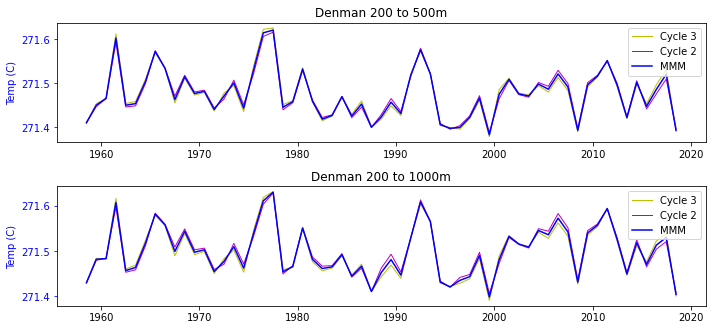

In [112]:
myr=36 #annual means start in 1958, seasonal in 59
yrs=np.arange(1958.5,2019.5,1)

fig = plt.figure(figsize=(10, 9))

ax1=plt.subplot(411)
ax1.plot(yrs,den_t_200to500[1,:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(yrs,den_t_200to500[0,:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(yrs,np.mean(den_t_200to500[:,:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Denman 200 to 500m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

ax1=plt.subplot(412)
ax1.plot(yrs,den_t_200to1000[1,:],linestyle='-',color='y',linewidth=1,label='Cycle 3')
ax1.plot(yrs,den_t_200to1000[0,:],linestyle='-',color='m',linewidth=1,label='Cycle 2')
ax1.plot(yrs,np.mean(den_t_200to1000[:,:],axis=0),linestyle='-',color='b',linewidth=1.5,label='MMM')
#ax1.plot(as_mr_yr[:,0],np.zeros((61-myr,1)),linestyle=':',color='k',linewidth=1)
#plt.ylim((273.2,274.0))
ax1.set_ylabel('Temp (C)',color='b')
ax1.tick_params('y', colors='b')
plt.title('Denman 200 to 1000m')
#ax1.set_xlabel('Years')
ax1.legend(fontsize=10)

plt.tight_layout()

#Plot ACCCESS-OM2-01 model bathymetry

In [68]:

# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

In [69]:
# topography data for plotting:
lat_slice  = slice(-82,-50.04) #-50.04-

ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)

In [70]:
np.nanmax(ht.values)

5808.6567

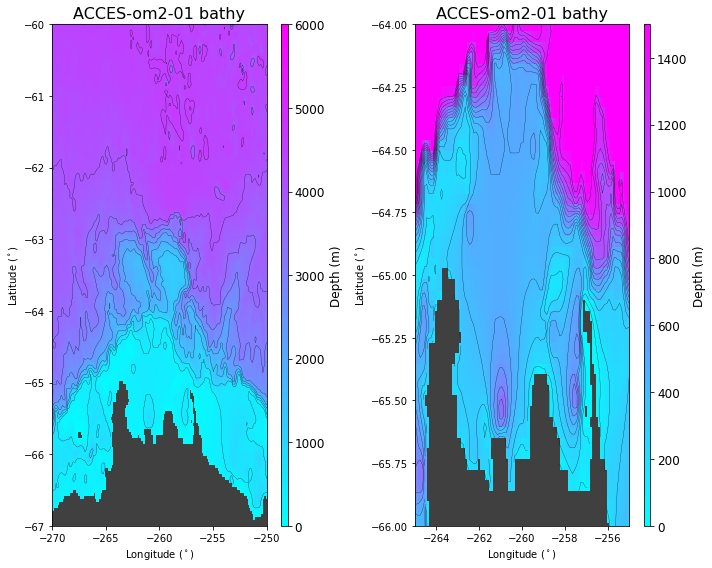

In [86]:
#np.nanmax(ht.values)
clev = np.arange(0,6000,10)
clev2 = np.arange(0,6000,500)
fontsize=12

plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=6000,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-67,-60])
plt.xlim([-270,-250])
plt.title('ACCES-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

clev = np.arange(0,1500,5)
clev2 = np.arange(0,1500,100)

plt.subplot(1,2,2)
plt.gca().patch.set_color('.25')
p1=plt.pcolormesh(ht.xt_ocean,ht.yt_ocean,ht,vmin=0, vmax=1500,cmap=plt.cm.cool)
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=clev2,colors='k',linewidths=0.25)
plt.xlabel('Longitude ($^\circ$)')
plt.ylabel('Latitude ($^\circ$)')
plt.ylim([-66,-64])
plt.xlim([-265,-255])
plt.title('ACCES-om2-01 bathy',fontsize = 16)
# colorbar:
ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
cbar = plt.colorbar(p1, cax=cax,orientation = 'vertical',extend = 'neither')
cbar.set_label(r'Depth (m)',fontsize=fontsize,labelpad=5)
cbar.ax.tick_params(labelsize=fontsize)

plt.tight_layout()